### Predicting Tomorrow's Weather in Edinburgh: implementing regression models

In this notebook, I replicate a weather prediction model as presented by Vik Paruchuri from Dataquest. I download a dataset on Edinburgh's UK weather from 1970-2019 to train and test a daily weather prediction model using linear regression.

Note: The material that this notebook is based off of can be found here: https://github.com/dataquestio/project-walkthroughs/tree/master/weather

### Download the data

Downloading the data:
* https://www.ncdc.noaa.gov/cdo-web/search
* search for Edinburgh, UK
* download daily summaries from 1970 onwards
* documentation for the dataset can be found here: https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf

### Import necessary library and the dataset

In [1]:
## Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

In [2]:
## Import the dataset (in CSV format) & observe the columns / general structure
weather = pd.read_csv('edinburgh_weather_noaa.csv',index_col = "DATE")
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,PRCP,PRCP_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
DATE,,,,,,,,,,,
1970-01-01,UKE00105887,"PENICUIK, UK",55.8239,-3.2258,185.0,0.0,",,E",5.0,",,E",-0.6,",,E"
1970-01-02,UKE00105887,"PENICUIK, UK",55.8239,-3.2258,185.0,1.8,",,E",0.6,",I,E",1.1,",I,E"
1970-01-03,UKE00105887,"PENICUIK, UK",55.8239,-3.2258,185.0,0.0,",,E",1.7,",,E",-5.0,",,E"
1970-01-04,UKE00105887,"PENICUIK, UK",55.8239,-3.2258,185.0,0.0,",,E",-0.6,",,E",-3.3,",,E"
1970-01-05,UKE00105887,"PENICUIK, UK",55.8239,-3.2258,185.0,8.4,",,E",-2.8,",,E",-6.7,",,E"


### Data cleaning

In [3]:
## Check for % of obsv. with null values in the dataset
(weather.isnull().sum() / weather.shape[0]) * 100

STATION            0.000000
NAME               0.000000
LATITUDE           0.000000
LONGITUDE          0.000000
ELEVATION          0.000000
PRCP               1.391798
PRCP_ATTRIBUTES    1.391798
TMAX               0.945320
TMAX_ATTRIBUTES    0.945320
TMIN               0.620108
TMIN_ATTRIBUTES    0.620108
dtype: float64

In [4]:
## Let's just keep the columns that are relevant. We want to just keep the precipitation, max temp., and min temp.
core_weather = weather[["PRCP", "TMAX", "TMIN"]].copy()
core_weather.columns = ["precip", "temp_max", "temp_min"]

In [5]:
## The bulk of the observations (~41%) have precipiation level of 0
## In this case, it might be reasonable to fill all the null values with '0' and not lose explanatory values of the data
core_weather['precip'].value_counts() / core_weather.shape[0]

0.0     0.407618
0.2     0.043077
0.1     0.039411
0.4     0.025466
0.3     0.024639
          ...   
31.3    0.000028
30.2    0.000028
39.8    0.000028
45.9    0.000028
29.7    0.000028
Name: precip, Length: 380, dtype: float64

In [6]:
## Filling the null values of the 'precip' column with zeros
core_weather['precip'] = core_weather['precip'].fillna(0)

Below, we can see that the 'temp_max' data is empty for stretches of days while the pattern is not that predictable for 'temp_min' data.

For 'temp_max', it might be valuable to fill these null values based on the averages of the known values from the same day over the past years. For example, 2017-09-22 data for 'temp_max' could be calculated by taking the average of the 'temp_max' values for 2014-09-22, 2015-09-22, 2016-09-22... 

For simplicity's sake, and because the % of null values is relatively small (less than 1%), we use a built-in function to fill the nulls, i.e. 'ffill', which forward fills the null values based on the last known value.

In [7]:
## Checking the instances where the 'temp_max' and 'temp_min' columns are null.
core_weather[core_weather['temp_max'].isnull()][90:100]

,precip,temp_max,temp_min
DATE,,,
2017-09-22,0.0,NaN,NaN
2017-09-23,0.2,NaN,NaN
2017-09-24,0.0,NaN,10.0
2017-09-25,6.4,NaN,NaN
2017-09-26,0.0,NaN,9.3
2017-09-27,1.1,NaN,9.2
2017-09-28,0.0,NaN,NaN
2017-09-29,0.0,NaN,9.8
2017-09-30,1.9,NaN,NaN


In [8]:
core_weather[core_weather['temp_min'].isnull()][80:90]

,precip,temp_max,temp_min
DATE,,,
2012-03-20,0.0,NaN,NaN
2012-03-21,0.0,NaN,NaN
2012-03-22,0.0,14.0,NaN
2012-03-23,0.0,13.5,NaN
2012-05-08,0.0,12.2,NaN
2012-05-09,11.3,NaN,NaN
2012-05-11,6.1,14.0,NaN
2012-05-15,0.2,NaN,NaN
2012-05-18,4.4,11.7,NaN


In [9]:
## Filling the null of the two columns using the ffill method
core_weather[['temp_max','temp_min']] = core_weather[['temp_max','temp_min']].fillna(method="ffill")

In [10]:
## Let's check again for nulls and verify we have taken care of all of them.
(core_weather.isnull().sum() / core_weather.shape[0]) * 100

precip      0.0
temp_max    0.0
temp_min    0.0
dtype: float64

We want to extract useful information from the date index. Currently, pandas just knows it as string values. We can convert it to a datetime object so that we can get useful information such as year, month, and day from it.

In [11]:
## Converting the index to datetime
core_weather.index = pd.to_datetime(core_weather.index)
core_weather.index

DatetimeIndex(['1970-01-01', '1970-01-02', '1970-01-03', '1970-01-04',
               '1970-01-05', '1970-01-06', '1970-01-07', '1970-01-08',
               '1970-01-09', '1970-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='DATE', length=36284, freq=None)

In [12]:
## As mentioned above, this allows us to get useful information, e.g. the year value
core_weather.index.year

Int64Index([1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970,
            ...
            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
           dtype='int64', name='DATE', length=36284)

<AxesSubplot:xlabel='DATE'>

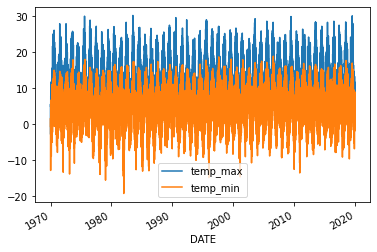

In [13]:
## Finally, let's get see how the data looks over time
core_weather[["temp_max", "temp_min"]].plot()

<AxesSubplot:xlabel='DATE'>

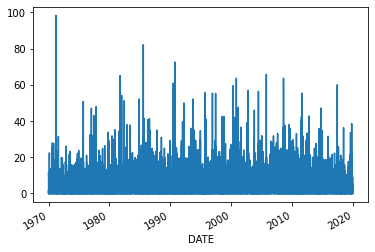

In [14]:
core_weather["precip"].plot()

### Building initial predictive models

There are many ways one could go about building a weather prediction model. You can look at all historical data to get insights on how the weather will look like over the coming week or month.

**For the purpose of this model, we will predict tomorrow's weather using the information we have today.**

To have a model that predicts tomorrow's temperature using the information we have today, we need to build a target variable column that represents tomorrow's weather. We will use this target data to train the model.

In [15]:
core_weather["target"] = core_weather.shift(-1)["temp_max"]
core_weather.head()

,precip,temp_max,temp_min,target
DATE,,,,
1970-01-01,0.0,5.0,-0.6,0.6
1970-01-02,1.8,0.6,1.1,1.7
1970-01-03,0.0,1.7,-5.0,-0.6
1970-01-04,0.0,-0.6,-3.3,-2.8
1970-01-05,8.4,-2.8,-6.7,-2.2


In [16]:
## Because the target variable is using the shifted data, the last entry is empty. We will just remove that last row.
core_weather.tail()

,precip,temp_max,temp_min,target
DATE,,,,
2019-12-27,2.0,11.3,3.0,11.7
2019-12-28,0.0,11.7,5.8,10.8
2019-12-29,0.0,10.8,9.0,7.0
2019-12-30,0.0,7.0,8.8,7.0
2019-12-31,0.2,7.0,-1.3,NaN


In [17]:
core_weather = core_weather.iloc[:-1,:].copy()

In [18]:
core_weather

,precip,temp_max,temp_min,target
DATE,,,,
1970-01-01,0.0,5.0,-0.6,0.6
1970-01-02,1.8,0.6,1.1,1.7
1970-01-03,0.0,1.7,-5.0,-0.6
1970-01-04,0.0,-0.6,-3.3,-2.8
1970-01-05,8.4,-2.8,-6.7,-2.2
...,...,...,...,...
2019-12-26,0.6,11.5,1.6,11.3
2019-12-27,2.0,11.3,3.0,11.7
2019-12-28,0.0,11.7,5.8,10.8


In [19]:
## We see that the number of rows does not match the number of years; removing duplicate dates
core_weather = core_weather.loc[~core_weather.index.duplicated(), :]

In [20]:
core_weather

,precip,temp_max,temp_min,target
DATE,,,,
1970-01-01,0.0,5.0,-0.6,0.6
1970-01-02,1.8,0.6,1.1,1.7
1970-01-03,0.0,1.7,-5.0,-0.6
1970-01-04,0.0,-0.6,-3.3,-2.8
1970-01-05,8.4,-2.8,-6.7,-2.2
...,...,...,...,...
2019-12-26,0.6,11.5,1.6,11.3
2019-12-27,2.0,11.3,3.0,11.7
2019-12-28,0.0,11.7,5.8,10.8


In [21]:
core_weather = core_weather.sort_index()

### Ridge Regression Model

We will first use a ridge regression model for prediction. Ridge regression shrinks the effects of some of the variables in the model using an L2 regularisation method (but never reduces the effects to zero, like Lasso regression does). This effectively reduces the complexity of the model. Reducing the complexity may be preferable since in building machine learning models, we want to build a model that strikes a good bias-variance tradeoff. We don't want the models to overfit to the training data and thus result in a lower predictive power. We want to build a model that can perform well on test data – ridge regression is a way to achieve this balance.

#### Prep dataset for prediction

In [22]:
## We will use all the data up until the end of 2018 in the training dataset. We use the 2019 as test data.
predictors = ["precip", "temp_max", "temp_min"]
train = core_weather.loc[:"2018-12-31"]
test = core_weather.loc["2019-01-01":]

In [23]:
train

,precip,temp_max,temp_min,target
DATE,,,,
1970-01-01,0.0,5.0,-0.6,0.6
1970-01-02,1.8,0.6,1.1,1.7
1970-01-03,0.0,1.7,-5.0,-0.6
1970-01-04,0.0,-0.6,-3.3,-2.8
1970-01-05,8.4,-2.8,-6.7,-2.2
...,...,...,...,...
2018-12-27,0.2,10.5,5.3,10.0
2018-12-28,2.3,10.0,6.9,10.2
2018-12-29,0.3,10.2,3.9,10.2


In [24]:
test

,precip,temp_max,temp_min,target
DATE,,,,
2019-01-01,0.0,1.3,7.5,6.2
2019-01-02,0.0,6.2,-5.6,6.5
2019-01-03,0.0,6.5,-5.0,6.4
2019-01-04,0.0,6.4,1.3,10.8
2019-01-05,0.0,10.8,1.5,10.2
...,...,...,...,...
2019-12-26,0.6,11.5,1.6,11.3
2019-12-27,2.0,11.3,3.0,11.7
2019-12-28,0.0,11.7,5.8,10.8


#### Run basic model

In [25]:
## Now let's run the model
reg = Ridge(alpha=0.1)
reg.fit(train[predictors],train['target'])
model_predictions = reg.predict(test[predictors])

Now that the model is run, we use the RMSE metric to assess predictive performance. RMSE takes the square root of the popular MSE metric – and gives an indication of the performance in the same unit as the target variable, making it easier to interpret



In [26]:
model_rmse = math.sqrt(mean_squared_error(test['target'],model_predictions))
model_r2 = r2_score(test['target'],model_predictions)
print(f'Model RMSE: {model_rmse}')
print(f'Model R-squared: {model_r2}')

Model RMSE: 2.369436470984807
Model R-squared: 0.8223107306299469


Let's see how the prediction stack up to actual values in a chart

In [27]:
combined = pd.concat([test['target'],pd.Series(model_predictions,index=test.index)], axis=1)
combined.columns = ['actual','predictions']
combined

,actual,predictions
DATE,,
2019-01-01,6.2,3.011021
2019-01-02,6.5,6.180255
2019-01-03,6.4,6.486858
2019-01-04,10.8,6.906533
2019-01-05,10.2,10.712889
...,...,...
2019-12-26,11.3,11.325762
2019-12-27,11.7,11.270178
2019-12-28,10.8,11.833419


<AxesSubplot:xlabel='DATE'>

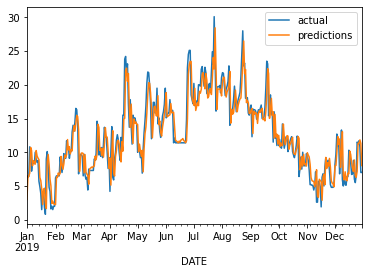

In [28]:
combined.plot()

Great! We have built a rough ridge regression model to predict weather. From the plot above, we can see that the predictions and the actual values line up pretty well.

However, let's see whether we can make any improvements.

There are other improvements that can be made to the model – which I will be adding below:
- engineering features: what features can we add from this dataset (e.g. monthly average? day of the year average?)
- can we use other regression models, e.g. 

#### Engineering additional features

There are a few features that would be nice to create:
1. What's the average temparature of the month of the year (e.g. average temperature of December)?
2. What's the average temperature of the day of the year (e.g. Dec 13th)?


In [29]:
core_weather["monthly_avg"] = core_weather["temp_max"].groupby(core_weather.index.month).apply(lambda x: x.expanding(1).mean())
core_weather["day_of_year_avg"] = core_weather["temp_max"].groupby(core_weather.index.day_of_year).apply(lambda x: x.expanding(1).mean())

In [30]:
## We will add the additional features into the model
predictors = ["precip", "temp_max", "temp_min","monthly_avg","day_of_year_avg"]
train = core_weather.loc[:"2018-12-31"]
test = core_weather.loc["2019-01-01":]

In [31]:
## Now let's run the model
reg = Ridge(alpha=0.1)
reg.fit(train[predictors],train['target'])
model_predictions = reg.predict(test[predictors])

In [32]:
model_rmse = math.sqrt(mean_squared_error(test['target'],model_predictions))
model_r2 = r2_score(test['target'],model_predictions)
print(f'Model RMSE: {model_rmse}')
print(f'Model R-squared: {model_r2}')

Model RMSE: 2.3172443199812136
Model R-squared: 0.8300525250457833


Here, we can see that the addition of these features have resulted in a lower error score. Both the RMSE and R-squared values for this model is lower than the previous one.

In [33]:
combined = pd.concat([test['target'],pd.Series(model_predictions,index=test.index)], axis=1)
combined.columns = ['actual','predictions']
combined

,actual,predictions
DATE,,
2019-01-01,6.2,2.831439
2019-01-02,6.5,5.987410
2019-01-03,6.4,6.229781
2019-01-04,10.8,6.251597
2019-01-05,10.2,9.270975
...,...,...
2019-12-26,11.3,9.826799
2019-12-27,11.7,9.729044
2019-12-28,10.8,10.056255


<AxesSubplot:xlabel='DATE'>

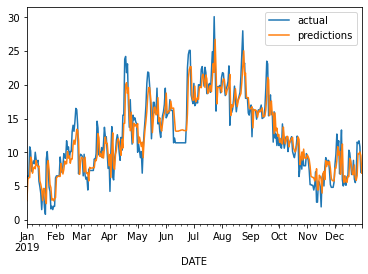

In [34]:
combined.plot()